In [1]:
!pip install -U transformers --q
!pip install -U accelerate --q
!pip install -U datasets --q
!pip install -U bertviz --q
!pip install -U umap-learn --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is i

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer,TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score,f1_score
import pandas as pd
import numpy as np
from datasets import load_dataset
import torch
import bertviz


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
dataset = load_dataset('dair-ai/emotion',trust_remote_code=True) #'stanfordnlp/imdb')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
classes = dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [10]:
df = pd.DataFrame(dataset['train'])
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

In [12]:
df['word_length'] = df['text'].str.split().apply(len)

In [13]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'word_length'}, xlabel='label'>

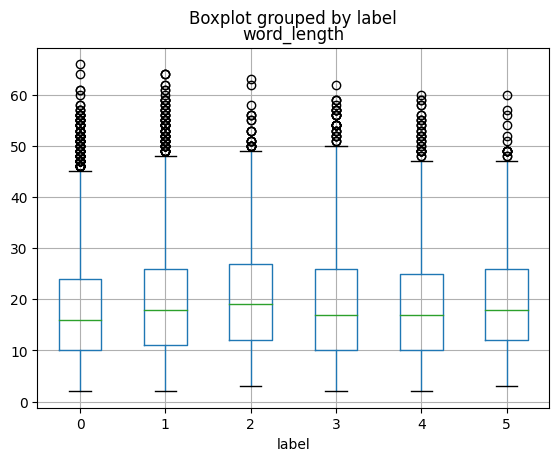

In [14]:
df.boxplot('word_length',by = 'label')

In [15]:
model_ckpt = 'distilbert-base-uncased'

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
def tokenize(x):
  return tokenizer(x['text'],padding = True,truncation=True,max_length = 512,return_tensors='pt')

In [18]:
dataset_embedded = dataset.map(tokenize,batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels = len(classes)).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
data_collator = DataCollatorWithPadding(tokenizer)

In [25]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm=False)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"Accuracy": acc, "F1": f1}

In [28]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_embedded['train'],
                  eval_dataset=dataset_embedded['validation'],
                  tokenizer=tokenizer)

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.166301,0.931000,0.931477
2,0.075200,0.176535,0.932500,0.932315


TrainOutput(global_step=500, training_loss=0.07515006256103515, metrics={'train_runtime': 234.0802, 'train_samples_per_second': 136.705, 'train_steps_per_second': 2.136, 'total_flos': 718554424246272.0, 'train_loss': 0.07515006256103515, 'epoch': 2.0})

In [30]:
preds_outputs = trainer.predict(dataset_embedded['test'])
preds_outputs.metrics

{'test_loss': 0.19018802046775818,
 'test_Accuracy': 0.9215,
 'test_F1': 0.9212203280310848,
 'test_runtime': 3.903,
 'test_samples_per_second': 512.424,
 'test_steps_per_second': 8.199}

In [31]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = dataset_embedded['test'][:]['label']

In [32]:

from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       581
           1       0.93      0.94      0.94       695
           2       0.78      0.80      0.79       159
           3       0.91      0.92      0.92       275
           4       0.90      0.91      0.90       224
           5       0.81      0.70      0.75        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [33]:

text = 'You have done a good job'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(1, 'joy')